<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_7/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_ASPP_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация ASPP сети
В этом уроке мы создадим еще еще одну сегментационную FCN модель на основе блока ASPP (Atrous Spatial Pyramid Pooling), который основан на дилатационных свёртках (Atrous Conv, Dilated Conv)

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [1]:
import numpy as np

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.2


### Создание ASPP модели
В этом примере мы будем создавать модель `ASPPNet` через собственный класс, наследованный от `tf.keras.Model`. Кроме того, будем использовать возможность модульного создания нейросетей. Сначала создадим отдельно модель для ASPP блока (блок, который содержит только дилатационные свёртки и применяется между энкодером и декодером), которая по сути будет являться самостоятельным слоем. А затем создадим финальную модель `ASPPNet`, в который `ASPPBlock` будет использоваться как слой между Энкодером и Декодером.

В ASPP блоке (`ASPPBlock`) ко входному тензору параллельно применяются обычная свёртка 1x1 и несколько дилатационных свёрток. Затем все эти резульаты конкатенируются. Далее "перемешиваем" каналы полученного тензора с помощью еще одной свёртки 1x1.

В финальной ASPP модели (`ASPPNet`) в качестве Энкодера будем использовать стандартные свёртки и пулинги. Далее в боттлнеке (в середине сети) применим слой ASPPBlock. А в Декодере будем использовать более простую архитектуру: меньше свёрток, повышение размерности с помощью двух билинейных интерполяций (`tf.image.resize`). Кроме того, в сети присутствуют две проброшенные связи.

In [2]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()

### Задания


**[ЗАДАНИЕ 1]** Вопрос: почему в ASPPNet в первой билинейной интерполяции (`tf.image.resize`) в качестве желаемого выходного размера тензора мы используем размер тензора `out_enc_mid`?


**[ЗАДАНИЕ 2]** Реализуйте пайплайн обучения для модели ASPPNet: подготовка данных, лосс, обучение, тестирование. Используйте материалы из предыдущего практического урока. Обучите модель и сравните время обучения с временем обучения более простых версий FCN из предыдущих уроков.

In [4]:

import imageio
import matplotlib.pyplot as plt
img = imageio.imread('6.11_me_256.png')
img = img.astype(np.float32) / 255

gt = imageio.imread('6.11_me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]


train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

In [5]:
# Ваш код здесь
%%time
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
hist = model.fit(train_x,train_y, epochs=100, batch_size=1)

Epoch 1/100
2/2 [==============================] - 16s 41ms/step - loss: 0.6745 - accuracy: 0.5051
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 9.3762 - accuracy: 0.8159
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6744 - accuracy: 0.8159
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6606 - accuracy: 0.8159
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6028 - accuracy: 0.8159
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.5044 - accuracy: 0.8159
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 0.3921 - accuracy: 0.8159
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3277 - accuracy: 0.8159
Epoch 9/100
2/2 [==============================] - 0s 42ms/step - loss: 0.2430 - accuracy: 0.8159
Epoch 10/100
2/2 [==============================] - 0s 42ms/step - loss: 0.2041 - accuracy: 0.8745
Epoch 11/100
2/2 [

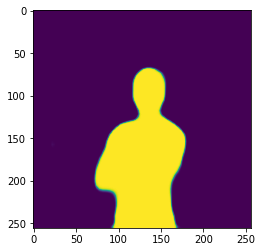

In [7]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

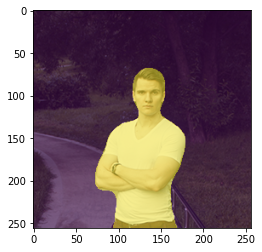

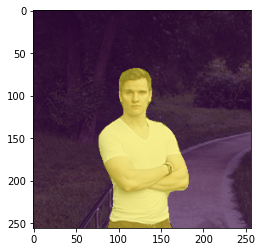

In [8]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()